In [ ]:
# Copyright [2021] [Jeanny Zhang]

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# This is an exploratory project on stock prediction using deep learning.
# Work derived from: https://github.com/JordiCorbilla/stock-prediction-deep-neural-learning

In [82]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM

# changeable parameters
STOCK = "MSFT"
START_DATE = "2016-01-01"
END_DATE = "2021-12-31"
DATE_FORMAT = '%Y-%m-%d'
TIMESTEP = 3
EPOCHS = 100
BATCH_SIZE = 32

In [83]:
# get the closing prices of the stock
df = yf.download(STOCK, start = START_DATE, end = END_DATE)[['Close']]
df = df.reset_index()
# get the ticker of the stock
ticker = yf.Ticker(STOCK)
shortname = ticker.info['shortName']
currency = ticker.info['currency']

[*********************100%***********************]  1 of 1 completed


In [84]:
# find a split date
start = datetime.strptime(START_DATE, DATE_FORMAT)
end = datetime.strptime(END_DATE, DATE_FORMAT)
diff = (end - start)/10
split_date = datetime.strftime(start+8*diff, DATE_FORMAT)

# split the dataset into training and test
train = df[df['Date'] < split_date].copy()
train = train.set_index('Date')
test = df[df['Date'] >= split_date].copy()
test = test.set_index('Date')

# scale training data
min_max = MinMaxScaler(feature_range=(0, 1))
train_scaled = min_max.fit_transform(train)

# print(train.shape)
# print(test.shape)

In [85]:
# training data transformation
x_train = []
y_train = []
for i in range(TIMESTEP, train_scaled.shape[0]):
    x_train.append(train_scaled[i - TIMESTEP:i])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

total_data = pd.concat((train, test), axis=0)
inputs = total_data[len(total_data) - len(test) - TIMESTEP:]

# scale test data
test_scaled = min_max.fit_transform(inputs)

# test data transformation
x_test = []
y_test = []
for i in range(TIMESTEP, test_scaled.shape[0]):
    x_test.append(test_scaled[i - TIMESTEP:i])
    y_test.append(test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

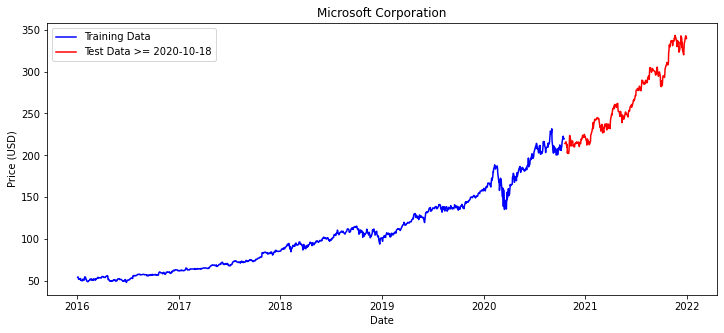

In [86]:
# plot training and test data
plt.figure(figsize=(12, 5))
plt.plot(train.Close, color='blue')
plt.plot(test.Close, color='red')
plt.ylabel('Price (' + currency + ')')
plt.xlabel("Date")
plt.legend(["Training Data", "Test Data >= " + split_date])
plt.title(shortname)
plt.show(block=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 100)            40800     
                                                                 
 dropout_16 (Dropout)        (None, 3, 100)            0         
                                                                 
 lstm_17 (LSTM)              (None, 3, 50)             30200     
                                                                 
 dropout_17 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_18 (LSTM)              (None, 3, 50)             20200     
                                                                 
 dropout_18 (Dropout)        (None, 3, 50)             0         
                                                                 
 lstm_19 (LSTM)              (None, 50)               

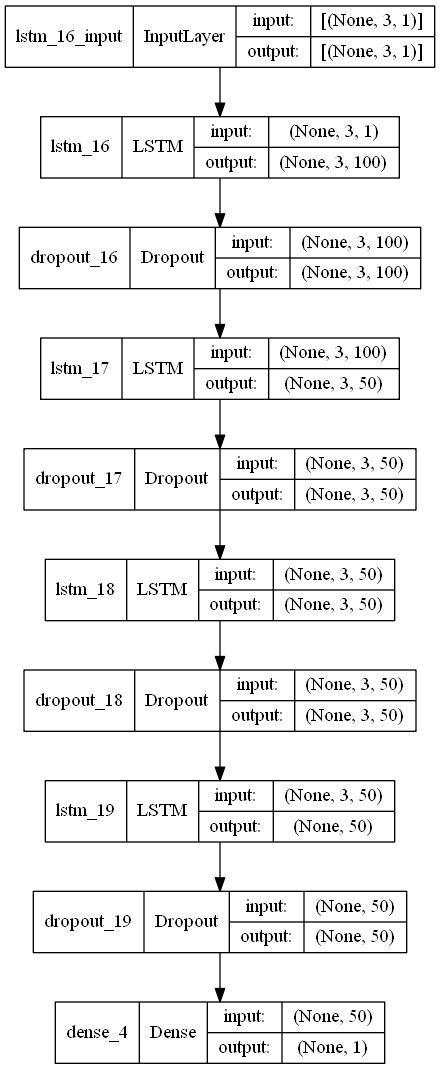

In [87]:
# build a lstm model
model = Sequential()
# 1st layer with Dropout regularisation
# * units = add 100 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
# * input_shape => Shape of the training dataset
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 2nd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 20% of the layers will be dropped
model.add(Dropout(0.2))
# 3rd LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
# * return_sequences = True to stack LSTM layers so the next LSTM layer has a three-dimensional sequence input
model.add(LSTM(units=50, return_sequences=True))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# 4th LSTM layer
# * units = add 50 neurons is the dimensionality of the output space
model.add(LSTM(units=50))
# 50% of the layers will be dropped
model.add(Dropout(0.5))
# Dense layer that specifies an output of one unit
model.add(Dense(units=1))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/100
38/38 [==============================] - 6s 35ms/step - loss: 0.0797 - MSE: 0.0797 - val_loss: 0.0320 - val_MSE: 0.0320
Epoch 2/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0094 - MSE: 0.0094 - val_loss: 0.0022 - val_MSE: 0.0022
Epoch 3/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0075 - MSE: 0.0075 - val_loss: 0.0040 - val_MSE: 0.0040
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0056 - MSE: 0.0056 - val_loss: 0.0016 - val_MSE: 0.0016
Epoch 5/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0056 - MSE: 0.0056 - val_loss: 0.0022 - val_MSE: 0.0022
Epoch 6/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0021 - val_MSE: 0.0021
Epoch 7/100
38/38 [==============================] - 0s 9ms/step - loss: 0.0045 - MSE: 0.0045 - val_loss: 0.0016 - val_MSE: 0.0016
Epoch 00007: early stopping


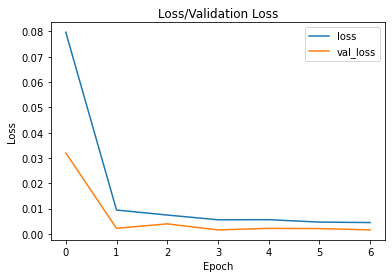

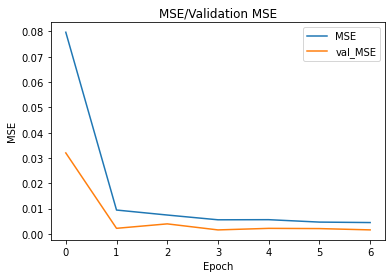

In [88]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name='MSE')])
history = model.fit(
    x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
    validation_data=(x_test, y_test), 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)]
)

# saving weights
# model.save(file_path, 'model_weights.h5'))

# plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss/Validation Loss')
plt.legend(loc='upper right')
plt.pause(0.001)
plt.show(block=True)

# plotting MSE
plt.plot(history.history['MSE'], label='MSE')
plt.plot(history.history['val_MSE'], label='val_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE/Validation MSE')
plt.legend(loc='upper right')
plt.pause(0.001)
plt.show(block=True)

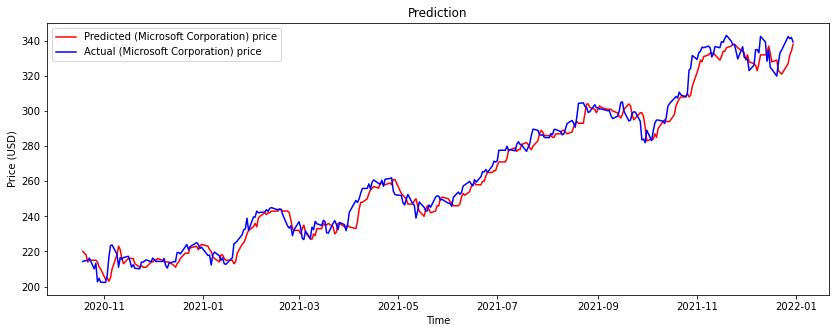

In [89]:
# get predictions
price_predicted = model.predict(x_test)
price_predicted = min_max.inverse_transform(price_predicted)
price_predicted = pd.DataFrame(price_predicted)

price_predicted.rename(columns={0: STOCK + '_predicted'}, inplace=True)
price_predicted = price_predicted.round(decimals=0)
price_predicted.index = test.index

# plot predictions
plt.figure(figsize=(14, 5))
plt.plot(price_predicted[STOCK + '_predicted'], color='red', label='Predicted (' + shortname + ') price')
plt.plot(test.Close, color='blue', label='Actual (' + shortname + ') price')
plt.xlabel('Time')
plt.ylabel('Price (' + currency + ')')
plt.legend()
plt.title('Prediction')
#plt.pause(0.001)
plt.show(block=True)